# Gesture recognition networks

### Imports

In [44]:
import os
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

from tqdm import tqdm
from torchvision import datasets, transforms, models

import numpy as np
import matplotlib.pyplot as plt

### Creating sorted classes for dataset



In [ ]:
data_dir = r".\..\EURECOM_Kinect_Face_Dataset\EURECOM_Kinect_Face_Dataset"
destination_dir = r".\HeadDataset"
os.makedirs(destination_dir, exist_ok=True)
os.makedirs(destination_dir+r"\001", exist_ok=True)
os.makedirs(destination_dir+r"\001", exist_ok=True)
os.makedirs(destination_dir+r"\002", exist_ok=True)
os.makedirs(destination_dir+r"\003", exist_ok=True)
os.makedirs(destination_dir+r"\004", exist_ok=True)
os.makedirs(destination_dir+r"\005", exist_ok=True)
os.makedirs(destination_dir+r"\006", exist_ok=True)
os.makedirs(destination_dir+r"\007", exist_ok=True)
os.makedirs(destination_dir+r"\008", exist_ok=True)
os.makedirs(destination_dir+r"\009", exist_ok=True)

for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    
    if os.path.isdir(folder_path):
        print(f"Processing folder: {folder}")
        
        # Loop through each class subfolder #
        for class_folder in os.listdir(folder_path):
            class_folder_path = os.path.join(folder_path, class_folder)
            
            if os.path.isdir(class_folder_path) and class_folder == "s2":
                print(f"  Class folder: {class_folder}")
                
                for class_Sfolder in os.listdir(class_folder_path):
                    class_Subfolder_path = os.path.join(class_folder_path, class_Sfolder)
                    
                    if os.path.isdir(class_Subfolder_path) and class_Sfolder == "RGB":
                        print(f"    Class Sub folder: {class_Sfolder}")

                        for filename in os.listdir(class_Subfolder_path):
                            file_path = os.path.join(class_Subfolder_path, filename)
                            # Left Profile
                            if os.path.isfile(file_path) and "LeftProfile" in filename:
                                print(f"        Moving file: {filename}")
                                shutil.copy(file_path, os.path.join(destination_dir+r"\001", filename))
                            # Light on
                            if os.path.isfile(file_path) and "LightOn" in filename:
                                print(f"        Moving file: {filename}")
                                shutil.copy(file_path, os.path.join(destination_dir+r"\002", filename))
                            # Neutral
                            if os.path.isfile(file_path) and "Neutral" in filename:
                                print(f"        Moving file: {filename}")
                                shutil.copy(file_path, os.path.join(destination_dir+r"\003", filename))
                            # OcclusionEyes
                            if os.path.isfile(file_path) and "OcclusionEyes" in filename:
                                print(f"        Moving file: {filename}")
                                shutil.copy(file_path, os.path.join(destination_dir+r"\004", filename))
                            # OcclusionMouth
                            if os.path.isfile(file_path) and "OcclusionMouth" in filename:
                                print(f"        Moving file: {filename}")
                                shutil.copy(file_path, os.path.join(destination_dir+r"\005", filename))
                            # OcclusionPaper
                            if os.path.isfile(file_path) and "OcclusionPaper" in filename:
                                print(f"        Moving file: {filename}")
                                shutil.copy(file_path, os.path.join(destination_dir+r"\006", filename))
                            # OpenMouth
                            if os.path.isfile(file_path) and "OpenMouth" in filename:
                                print(f"        Moving file: {filename}")
                                shutil.copy(file_path, os.path.join(destination_dir+r"\007", filename))
                            # RightProfile
                            if os.path.isfile(file_path) and "RightProfile" in filename:
                                print(f"        Moving file: {filename}")
                                shutil.copy(file_path, os.path.join(destination_dir+r"\008", filename))
                            # Smile
                            if os.path.isfile(file_path) and "Smile" in filename:
                                print(f"        Moving file: {filename}")
                                shutil.copy(file_path, os.path.join(destination_dir+r"\009", filename))

Processing folder: 0001
  Class folder: s2
    Class Sub folder: RGB
        Moving file: rgb_0001_s2_LeftProfile.bmp
        Moving file: rgb_0001_s2_LightOn.bmp
        Moving file: rgb_0001_s2_Neutral.bmp
        Moving file: rgb_0001_s2_OcclusionEyes.bmp
        Moving file: rgb_0001_s2_OcclusionMouth.bmp
        Moving file: rgb_0001_s2_OcclusionPaper.bmp
        Moving file: rgb_0001_s2_OpenMouth.bmp
        Moving file: rgb_0001_s2_RightProfile.bmp
        Moving file: rgb_0001_s2_Smile.bmp
Processing folder: 0002
  Class folder: s2
    Class Sub folder: RGB
        Moving file: rgb_0002_s2_LeftProfile.bmp
        Moving file: rgb_0002_s2_LightOn.bmp
        Moving file: rgb_0002_s2_Neutral.bmp
        Moving file: rgb_0002_s2_OcclusionEyes.bmp
        Moving file: rgb_0002_s2_OcclusionMouth.bmp
        Moving file: rgb_0002_s2_OcclusionPaper.bmp
        Moving file: rgb_0002_s2_OpenMouth.bmp
        Moving file: rgb_0002_s2_RightProfile.bmp
        Moving file: rgb_0002_s2_Smil

### Configuration

In [ ]:
class CONFIG:
    model_path = './BestModel.pt'
    num_epochs = 600
    lr = 1e-4
    batch_size = 10
    img_size = 224

### CNN structure

In [45]:
class CNN6Conv6FC(nn.Module):
    def __init__(self, num_classes=9):
        super(CNN6Conv6FC, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.bn6 = nn.BatchNorm2d(512)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc1 = nn.Linear(512 * 3 * 3, 1024)  
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, num_classes)  
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = self.pool(F.relu(self.bn6(self.conv6(x))))
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        
        x = self.fc6(x)
        
        return x


### Dataloader

In [ ]:
cfg = CONFIG()

transform = transforms.Compose([
    transforms.Resize((cfg.img_size, cfg.img_size)),  
    transforms.ToTensor(),        
    transforms.Grayscale(), 
    transforms.Normalize((0.5), (0.5))  
])

dataset = datasets.ImageFolder(root=r'.\HeadDataset', transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset =  data.random_split(dataset, [train_size, test_size])

trainloader =  data.DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=2)
testloader =  data.DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=2)


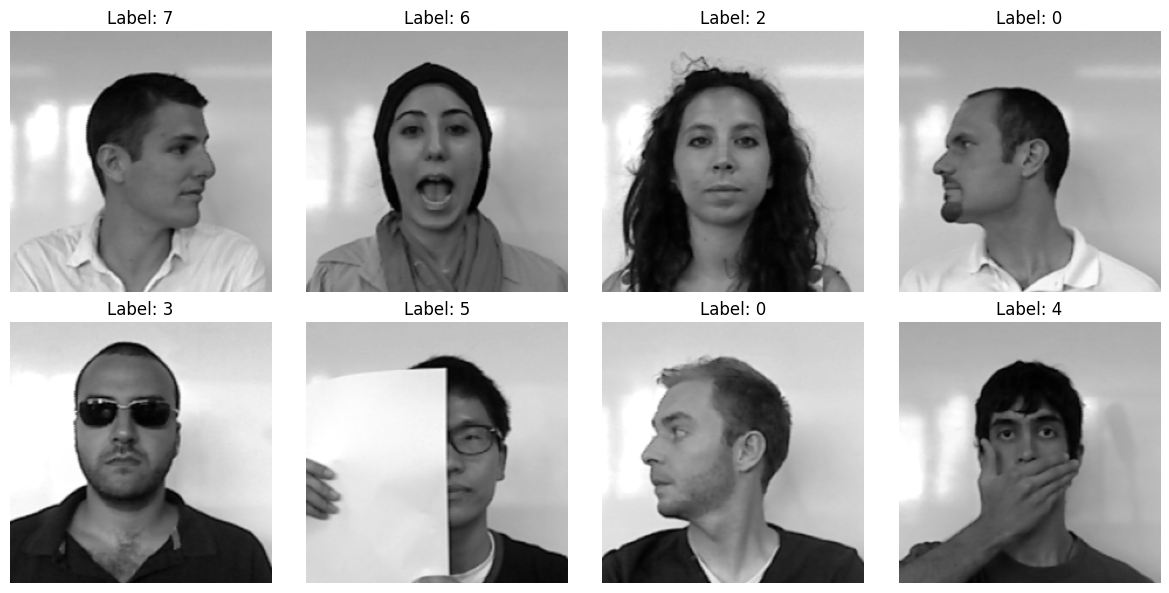

In [47]:
data_iter = iter(trainloader)
images, labels = next(data_iter)

random_indices = np.random.choice(images.size(0), 8, replace=False)
images = images[random_indices]
labels = labels[random_indices]

# Convert images to numpy and plot
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for i in range(8):
    ax = axes[i//4, i%4]
    image = images[i].squeeze(0).numpy() 
    ax.imshow(image, cmap='gray')  
    ax.axis('off')
    ax.set_title(f"Label: {labels[i].item()}")

plt.tight_layout()
plt.show()


### NET Setup and training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = CNN6Conv6FC(num_classes=9).to(device)
criterion = nn.CrossEntropyLoss()  # For classification tasks
optimizer = optim.Adam(model.parameters(), lr=cfg.lr)  # Adam optimizer with learning rate

Using device: cuda


In [ ]:
best_accuracy = 0.0
for epoch in range(cfg.num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    # Create a progress bar for the current epoch
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{cfg.num_epochs}", unit="batch")

    for i, (inputs, labels) in enumerate(progress_bar):  
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        # Update progress bar with current loss and accuracy
        progress_bar.set_postfix({
            'loss': loss.item(),
            'accuracy': (correct_predictions / total_predictions) * 100
        })

    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = (correct_predictions / total_predictions) * 100
    
    print(f"Epoch {epoch+1}/{cfg.num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_accuracy:.2f}%")

    # Validation loop
    model.eval()  
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():  
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)

            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    validation_accuracy = (correct_predictions / total_predictions) * 100
    print(f"Validation Accuracy: {validation_accuracy:.2f}%")
    if validation_accuracy > best_accuracy:
        torch.save(model.state_dict(), cfg.model_path)
print("Training finished.")


Epoch 1/20:   0%|          | 0/32 [00:00<?, ?batch/s]

Epoch 1/20: 100%|██████████| 32/32 [00:13<00:00,  2.38batch/s, loss=2.3, accuracy=17.6] 


Epoch 1/20 - Loss: 2.0649 - Accuracy: 17.65%
Validation Accuracy: 15.96%


Epoch 2/20: 100%|██████████| 32/32 [00:12<00:00,  2.56batch/s, loss=2.12, accuracy=22.7]


Epoch 2/20 - Loss: 1.9553 - Accuracy: 22.73%
Validation Accuracy: 19.15%


Epoch 3/20: 100%|██████████| 32/32 [00:12<00:00,  2.48batch/s, loss=0.983, accuracy=19.5]


Epoch 3/20 - Loss: 1.8365 - Accuracy: 19.52%
Validation Accuracy: 19.15%


Epoch 4/20: 100%|██████████| 32/32 [00:12<00:00,  2.57batch/s, loss=2.12, accuracy=21.7]


Epoch 4/20 - Loss: 1.8543 - Accuracy: 21.66%
Validation Accuracy: 18.09%


Epoch 5/20: 100%|██████████| 32/32 [00:12<00:00,  2.55batch/s, loss=1.91, accuracy=25.1]


Epoch 5/20 - Loss: 1.8179 - Accuracy: 25.13%
Validation Accuracy: 24.47%


Epoch 6/20: 100%|██████████| 32/32 [00:13<00:00,  2.38batch/s, loss=2.59, accuracy=25.7]


Epoch 6/20 - Loss: 1.8534 - Accuracy: 25.67%
Validation Accuracy: 26.60%


Epoch 7/20: 100%|██████████| 32/32 [00:11<00:00,  2.90batch/s, loss=2.24, accuracy=32.9]


Epoch 7/20 - Loss: 1.7129 - Accuracy: 32.89%
Validation Accuracy: 20.21%


Epoch 8/20: 100%|██████████| 32/32 [00:11<00:00,  2.90batch/s, loss=1.1, accuracy=32.9]  


Epoch 8/20 - Loss: 1.6349 - Accuracy: 32.89%
Validation Accuracy: 30.85%


Epoch 9/20: 100%|██████████| 32/32 [00:11<00:00,  2.81batch/s, loss=1.08, accuracy=33.2]


Epoch 9/20 - Loss: 1.5156 - Accuracy: 33.16%
Validation Accuracy: 18.09%


Epoch 10/20: 100%|██████████| 32/32 [00:12<00:00,  2.49batch/s, loss=0.00933, accuracy=34]


Epoch 10/20 - Loss: 1.4837 - Accuracy: 33.96%
Validation Accuracy: 32.98%


Epoch 11/20: 100%|██████████| 32/32 [00:12<00:00,  2.64batch/s, loss=0.99, accuracy=35.8]


Epoch 11/20 - Loss: 1.4836 - Accuracy: 35.83%
Validation Accuracy: 37.23%


Epoch 12/20: 100%|██████████| 32/32 [00:11<00:00,  2.82batch/s, loss=1.34, accuracy=36.6]


Epoch 12/20 - Loss: 1.5731 - Accuracy: 36.63%
Validation Accuracy: 32.98%


Epoch 13/20: 100%|██████████| 32/32 [00:11<00:00,  2.81batch/s, loss=1.88, accuracy=35.8]


Epoch 13/20 - Loss: 1.5332 - Accuracy: 35.83%
Validation Accuracy: 32.98%


Epoch 14/20: 100%|██████████| 32/32 [00:11<00:00,  2.84batch/s, loss=0.0132, accuracy=39.3]


Epoch 14/20 - Loss: 1.4285 - Accuracy: 39.30%
Validation Accuracy: 40.43%


Epoch 15/20: 100%|██████████| 32/32 [00:11<00:00,  2.85batch/s, loss=1.89, accuracy=43.6]


Epoch 15/20 - Loss: 1.3746 - Accuracy: 43.58%
Validation Accuracy: 40.43%


Epoch 16/20: 100%|██████████| 32/32 [00:11<00:00,  2.83batch/s, loss=1.85, accuracy=40.6]


Epoch 16/20 - Loss: 1.4445 - Accuracy: 40.64%
Validation Accuracy: 36.17%


Epoch 17/20: 100%|██████████| 32/32 [00:11<00:00,  2.69batch/s, loss=2.08, accuracy=44.9] 


Epoch 17/20 - Loss: 1.3801 - Accuracy: 44.92%
Validation Accuracy: 43.62%


Epoch 18/20: 100%|██████████| 32/32 [00:12<00:00,  2.51batch/s, loss=0.884, accuracy=49.5]


Epoch 18/20 - Loss: 1.1912 - Accuracy: 49.47%
Validation Accuracy: 50.00%


Epoch 19/20: 100%|██████████| 32/32 [00:14<00:00,  2.28batch/s, loss=1.86, accuracy=51.9] 


Epoch 19/20 - Loss: 1.1517 - Accuracy: 51.87%
Validation Accuracy: 47.87%


Epoch 20/20: 100%|██████████| 32/32 [00:11<00:00,  2.67batch/s, loss=1.11, accuracy=52.4] 


Epoch 20/20 - Loss: 1.1559 - Accuracy: 52.41%
Validation Accuracy: 51.06%
Training finished.
